In [17]:
import matplotlib.pyplot as plt
from pandasql import *
import pandas as pd
import zipfile

pysqldf = lambda query: sqldf(query, globals())

In [23]:
problem = "SPY-20000"
algorithm = "RCARF"
wsize = 500

# Loading results
# example path: "/home/cetrulin/Desktop/Andres/data/SPY-20000_RCARF_EVENTS.txt"
# logs=pd.read_csv(datadir, sep=';', parse_dates=True,infer_datetime_format=True)
datadir = "/home/bin/moa/src/moa-2017.06-sources/experiments/results/SPY-20000/1"

# Reading from a zip file
zipfilename = problem+"_"+algorithm+"_EVENTS_w"+str(wsize)
zf = zipfile.ZipFile(datadir+"/"+zipfilename+".zip") 
logs = pd.read_csv(zf.open(zipfilename+".txt"), sep=';', parse_dates=True,infer_datetime_format=True)
logs.columns = ['instance_n','model','event','error','n_models','n_active_warnings','models_on_warning','applicable_concepts_from_here','recurring_drift_to_history_id']
logs

,instance_n,model,event,error,n_models,n_active_warnings,models_on_warning,applicable_concepts_from_here,recurring_drift_to_history_id
0,1,0,Train example,1.000000,0,0,{},NaN,NaN
1,1,1,Train example,1.000000,0,0,{},NaN,NaN
2,1,2,Train example,1.000000,0,0,{},NaN,NaN
3,1,3,Train example,1.000000,0,0,{},NaN,NaN
4,1,4,Train example,1.000000,0,0,{},NaN,NaN
5,1,5,Train example,1.000000,0,0,{},NaN,NaN
6,1,6,Train example,1.000000,0,0,{},NaN,NaN
7,1,7,Train example,1.000000,0,0,{},NaN,NaN
8,1,8,Train example,1.000000,0,0,{},NaN,NaN
9,1,9,Train example,1.000000,0,0,{},NaN,NaN


In [24]:
query  = """
SELECT *
FROM
  logs l
WHERE
    l.event LIKE '%Train example%';
"""
training_patterns = pysqldf(query)

query  = """
SELECT *
FROM
  logs l
WHERE
    l.event LIKE '%RECURRING DRIFT%';
"""
recurring_drifts = pysqldf(query)

query  = """
SELECT *
FROM
  logs l
WHERE
    l.event LIKE '%DRIFT TO BKG MODEL%';
"""
bkg_drifts = pysqldf(query)

query  = """
SELECT *
FROM
  logs l
WHERE
    l.event LIKE '%WARNING%';
"""
#warnings = pysqldf(query) # not necessary as this info is included in every vector


In [25]:
query  = """
SELECT pattern, 
       round(avg(n_models)) AS n_models, 
       round(avg(n_active_warnings)) AS n_warnings, 
       sum(r_drift_flag) AS n_recurring_drifts, 
       sum(b_drift_flag) AS n_background_drifts
FROM (
    SELECT l.instance_n AS pattern, 
         -- l.model AS model, 
         -- COALESCE(avg(l.error),100) AS avg_error, 
         round(avg(l.n_models)) AS n_models, 
         round(avg(l.n_active_warnings)) AS n_active_warnings,
         CASE WHEN r.instance_n IS NOT NULL THEN 1 ELSE 0 END AS r_drift_flag,
         CASE WHEN b.instance_n IS NOT NULL THEN 1 ELSE 0 END AS b_drift_flag
    FROM (SELECT * FROM training_patterns) l
    LEFT JOIN (SELECT * FROM recurring_drifts) r ON (r.instance_n=l.instance_n)
    LEFT JOIN (SELECT * FROM bkg_drifts) b ON (b.instance_n=l.instance_n)
    GROUP BY l.instance_n, 
    -- l.model, 
    CASE WHEN r.instance_n IS NOT NULL THEN 1 ELSE 0 END, 
    CASE WHEN b.instance_n IS NOT NULL THEN 1 ELSE 0 END
) result
GROUP BY pattern;
"""

result = pysqldf(query)


In [26]:
query1  = """
SELECT *  
FROM result
WHERE n_recurring_drifts>0 or n_background_drifts>0;
"""

query2  = """
SELECT count(*) as rows, 
       count(distinct pattern) as patterns, 
       sum(n_recurring_drifts) as r_drifts, 
       sum(n_background_drifts) as b_drifts  
FROM result;
"""

pysqldf(query2)

,rows,patterns,r_drifts,b_drifts
0,18807,18807,65,12


In [41]:
query  = """
SELECT round(pattern/1) window_number, 
       min(pattern) as first_pattern_bucket,
       count(*) as rows, 
       avg(n_warnings) as n_warnings,
       sum(n_recurring_drifts) as r_drifts, 
       sum(n_background_drifts) as b_drifts  
FROM result
GROUP BY round(pattern/1);
"""
result_for_plot = pysqldf(query)

In [42]:
result_for_plot

,window_number,first_pattern_bucket,rows,n_warnings,r_drifts,b_drifts
0,1.0,1,1,0.0,0,0
1,2.0,2,1,0.0,0,0
2,3.0,3,1,0.0,0,0
3,4.0,4,1,0.0,0,0
4,5.0,5,1,0.0,0,0
5,6.0,6,1,0.0,0,0
6,7.0,7,1,0.0,0,0
7,8.0,8,1,0.0,0,0
8,9.0,9,1,0.0,0,0
9,10.0,10,1,0.0,0,0


In [47]:
# Save files with recurrent and background drifts

# Get instances numbers where there was a recurring drift
rdrift_output_name = problem+"_"+algorithm+"_"+'w500'+"_"+"recurring_drifts.txt"
query  = """
SELECT window_number as drifting_instances
FROM result_for_plot r
WHERE r.r_drifts=1 ;
"""
r_drifts = pysqldf(query)

# Get instances numbers where there was a background drift
nrdrift_output_name = problem+"_"+algorithm+"_"+'w500'+"_"+"non_recurring_drifts.txt"
query  = """
SELECT window_number as drifting_instances
FROM result_for_plot r
WHERE r.b_drifts=1 ;
"""
nr_drifts = pysqldf(query)

# Export
r_drifts['drifting_instances'].to_csv(datadir+"/"+rdrift_output_name, sep=',', encoding='utf-8', index=False)
nr_drifts['drifting_instances'].to_csv(datadir+"/"+nrdrift_output_name, sep=',', encoding='utf-8', index=False)


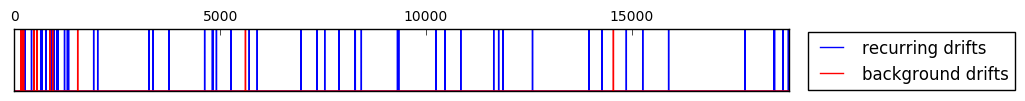

In [48]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10,0.8))

ax1 = fig.add_subplot(111)

ax1.plot(result_for_plot['r_drifts'], color='b', label="recurring drifts")
#ax1.set_xlabel('Number of patterns')

# ax1.set_ylabel('recurring drifts', color='b')

#ax2 = ax1.twinx()
ax1.plot(result_for_plot['b_drifts'], color='r', label="background drifts")
# ax2.set_ylabel('background drifts', color='r')

ax1.set_xlim(0,18826)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top') 

#red_patch = mpatches.Patch(color='red', label='background drifts')
#blue_patch = mpatches.Patch(color='blue', label='recurring drifts')
#plt.legend(handles=[red_patch,blue_patch])
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.2)

ax1.axes.get_yaxis().set_visible(False)

#plt.title("Drifts and warnings")
plt.show()

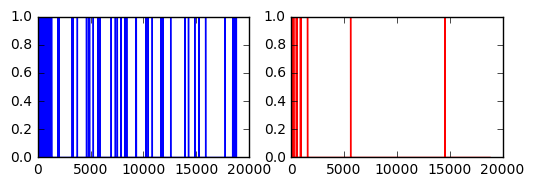

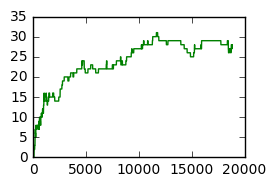

In [49]:
plt.figure(1)
plt.subplot(221)
plt.plot(result_for_plot['r_drifts'], color='b')

plt.subplot(222)
plt.plot(result_for_plot['b_drifts'], color='r')
plt.show()

plt.subplot(223)
plt.plot(result_for_plot['n_warnings'], color='g')
plt.show()
